In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

# https://docs.google.com/document/d/1LL4WSKmWF8637Fn9xz0GPnytO0-4xYwyy1hQJUpmsmY/edit?usp=sharing 

In [2]:
source = 'Version1.csv'
source = 'data.csv'
source = 'Version1.csv'

In [3]:
data = pd.read_csv(source)
pretty_cols = list(data.columns)
pretty_cols

['TAIP (ms)',
 'Respiratory Rate (breaths/min)',
 'I:E Ratio',
 'Target Peak Pressure (cm H2O)',
 'Observed Peak Pressure (cm H2O)',
 'PEEP (cm H2O)',
 'Lung Compliance (mL / cm H2O)',
 'Airway Resistance (cm H2O / (L/s) )',
 'Tidal Volume (mL)',
 'Flow (L/min)']

In [5]:
pretty_cols[0] = "Rise Time (ms)"
print(pretty_cols)
easy_cols = ['rise', 'rate', 'ie', 'p', 'p_observed', 'peep', 'compliance', 'resistance', 'tv', 'flow']
units = dict(zip(easy_cols,['ms', '/min', '', 'cmH2O', 'cmH2O', 'cmH2O', 'mL/cmH2O', 'cmH2O/L/s', 'mL', 'L/min']))
pretty = dict(zip(easy_cols, pretty_cols))
dependant = ['p_observed', 'tv', 'flow']
independant = [c for c in easy_cols if c not in dependant]
data.columns = easy_cols #[pretty_cols]
data['alveolarMV'] = (data.rate * (data.tv - 150)).clip(0, 100000)
pretty['alveolarMV'] = "Alveolar Minute Volume"
print(f"dependant {dependant}, independant {independant}")
data.sort_values(independant, inplace=True)
display(data.head())

['Rise Time (ms)', 'Respiratory Rate (breaths/min)', 'I:E Ratio', 'Target Peak Pressure (cm H2O)', 'Observed Peak Pressure (cm H2O)', 'PEEP (cm H2O)', 'Lung Compliance (mL / cm H2O)', 'Airway Resistance (cm H2O / (L/s) )', 'Tidal Volume (mL)', 'Flow (L/min)']
dependant ['p_observed', 'tv', 'flow'], independant ['rise', 'rate', 'ie', 'p', 'peep', 'compliance', 'resistance']


,rise,rate,ie,p,p_observed,peep,compliance,resistance,tv,flow,alveolarMV
17,0,12,2,20,15.667592,5,10,3,156.658474,47.425070,79.901687
32,0,12,2,20,15.137525,5,10,5,151.333968,43.565734,16.007614
47,0,12,2,20,14.607625,5,10,10,145.922050,38.088524,0.000000
62,0,12,2,20,14.514685,5,10,20,144.334189,34.960113,0.000000
2,0,12,2,20,14.520230,5,25,1,362.849229,52.815074,2554.190745


In [6]:
# These are our variables:
for i in independant:
    if len(data[i].unique()) > 1:
        values = data[i].unique()
        values.sort()
        print(f"{i} {values}" )

rise [   0  250  500 1000 2000]
rate [12 20 30]
compliance [ 10  25  50 100 200]
resistance [ 1  3  5 10 20]


In [7]:
def describe(data):
    print(f" {len(data.columns)} x {len(data)}")

In [8]:
# a function to extract the data for set of conditions
# makes use of the panda.query method
def get(data, filters):
     # rise = 0, rate = 12, ie = 2, p = 20, peep = 5, compliance = 100, resistance = 3
    query = ' & '.join([f"{c} == {v}" for c, v in filters.items()])
    # print (query)
    return data.query(query)

In [9]:
plt.rcParams['figure.figsize'] = [12, 12]
def sub_plot(data, filter_in, ax, series='rise', subseries='compliance', dependant='tv', title=''):
    filter = filter_in.copy()
    del filter[series]
    del filter[subseries]
    all_rows = get(data, filter)
    clean = all_rows.drop_duplicates(subset=[series, subseries], ignore_index=True, keep='first')
    if len(all_rows) > len(clean):
        print(f"WARNING went from {len(all_rows)} to {len(clean)} rows are cleaning {filter} (This shouldn't really be happening!)")
    df1 = clean.pivot(index=series, columns=subseries, values=dependant)
    df1.plot(ax=ax, title=title)

In [10]:
def plot_matrix(data, vars, units=units, dependant='tv', pretty=pretty):
    base_filter = {"rise": 0, "rate": 12, "ie": 2, "p": 20, "peep": 5, "compliance": 100, "resistance": 3}
    xvar = vars[2]
    yvar = vars[1]
    svar = vars[0]
    ssvar = vars[3]
    print(f"{vars} Rows = {xvar}, Cols = {yvar}, X={svar}, series={ssvar} ")
    xs = data[xvar].unique()
    ys = data[yvar].unique()
    xs.sort()
    ys.sort()
    fig, axes = plt.subplots(nrows=len(xs), ncols=len(ys), constrained_layout=True)
    fig.suptitle(f" {pretty[dependant]} by {xvar.title()}, {yvar.title()}, {svar.title()} and {ssvar.title()}", fontsize=16)
    for xi, x in enumerate(xs):
        for yi, y in enumerate(ys):
            # print(f"{xi}, {yi} {xvar}={x}\n{yvar}={y}, {svar}, {ssvar}")
            filter = base_filter.copy()
            filter[xvar] = x
            filter[yvar] = y
            # print(filter)
            ax = axes[xi, yi]
            ax.set_ylim(0, 1000 if dependant=='tv' else 15000)
            if len(xs) - xi > 1:
                # hiding x marks
                ax.xaxis.label.set_visible(False)
                ax.get_xaxis().set_visible(False)
            if yi > 0:
                # hiding yx marks
                ax.yaxis.label.set_visible(False)
                ax.get_yaxis().set_visible(False)
            sub_plot(data, filter, ax, series=svar, subseries=ssvar, dependant=dependant)
            if xi == 0 and len(ys) - yi == 1:
                ax.legend(loc='upper right', title=f"{ssvar.title()}\n({units[ssvar]})")
            else:
                # hiding legend!
                ax.legend().set_visible(False)
            if xi == 0:
                ax.set_title(f"{yvar.title()} {y}{units[yvar]}")
            if yi == 0:
                ax.set_ylabel(f"{xvar.title()}={x}{units[xvar]}")
            ax.set_xlabel(pretty[svar])
    plt.show()

['rise', 'rate', 'compliance', 'resistance'] Rows = compliance, Cols = rate, X=rise, series=resistance 
WARNING went from 25 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 20, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 30, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 25} (This shouldn't really be happening!)


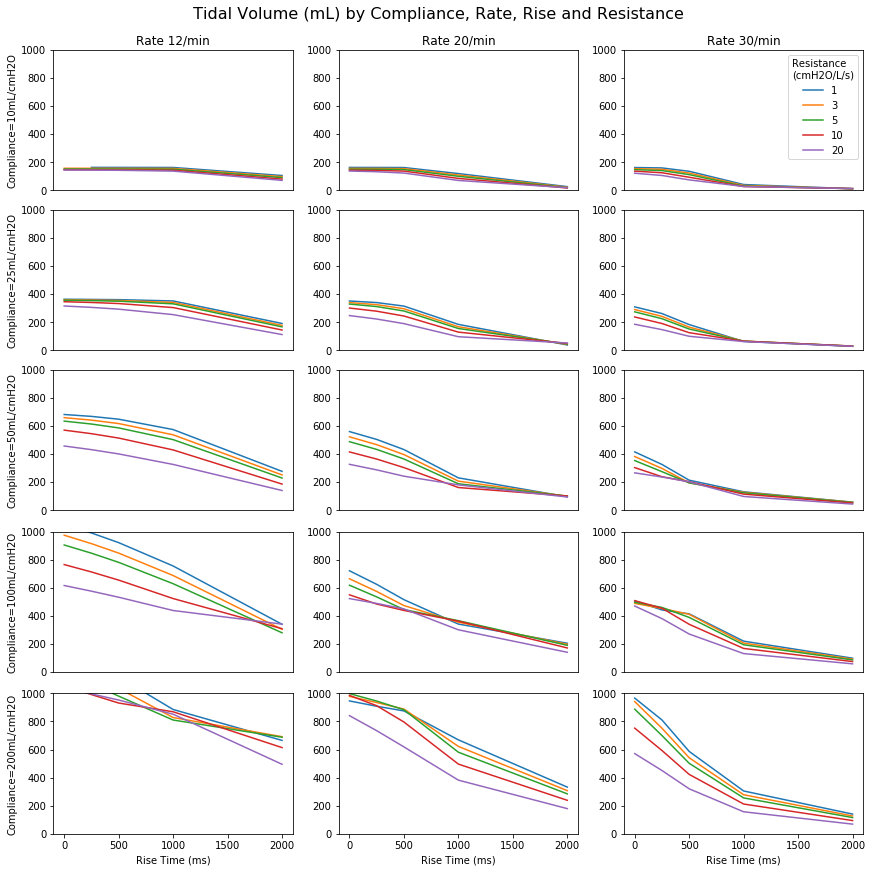

['rise', 'rate', 'compliance', 'resistance'] Rows = compliance, Cols = rate, X=rise, series=resistance 
WARNING went from 25 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 20, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 30, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'compliance': 25} (This shouldn't really be happening!)


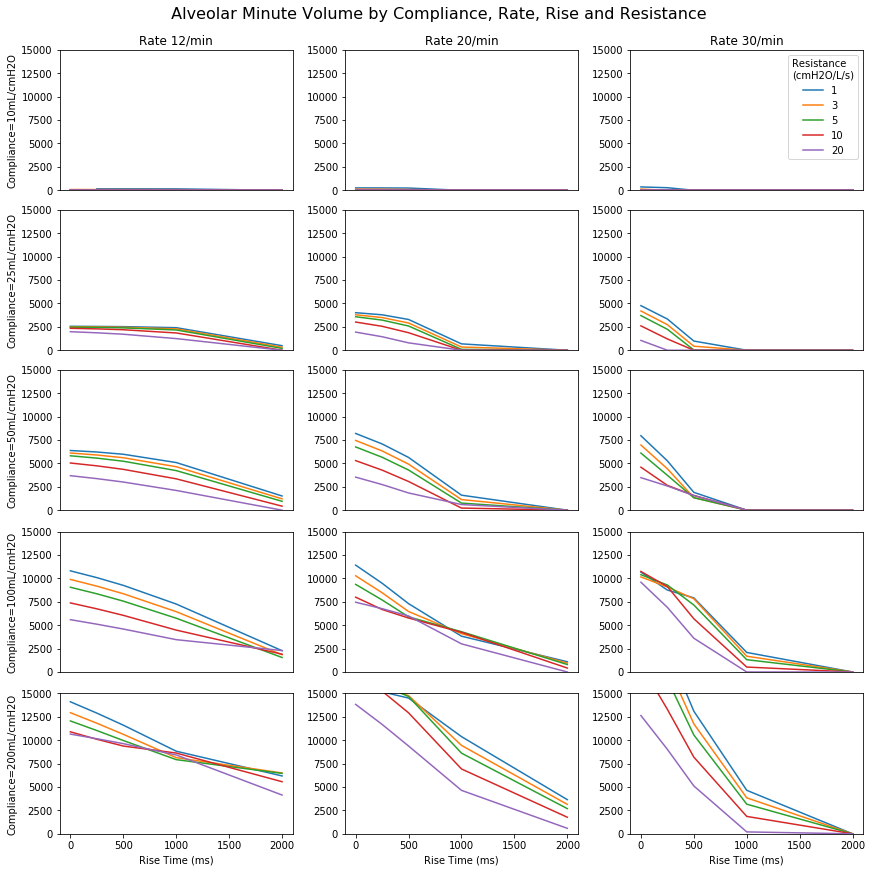

['rise', 'rate', 'resistance', 'compliance'] Rows = resistance, Cols = rate, X=rise, series=compliance 
WARNING went from 26 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 20, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 30, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)


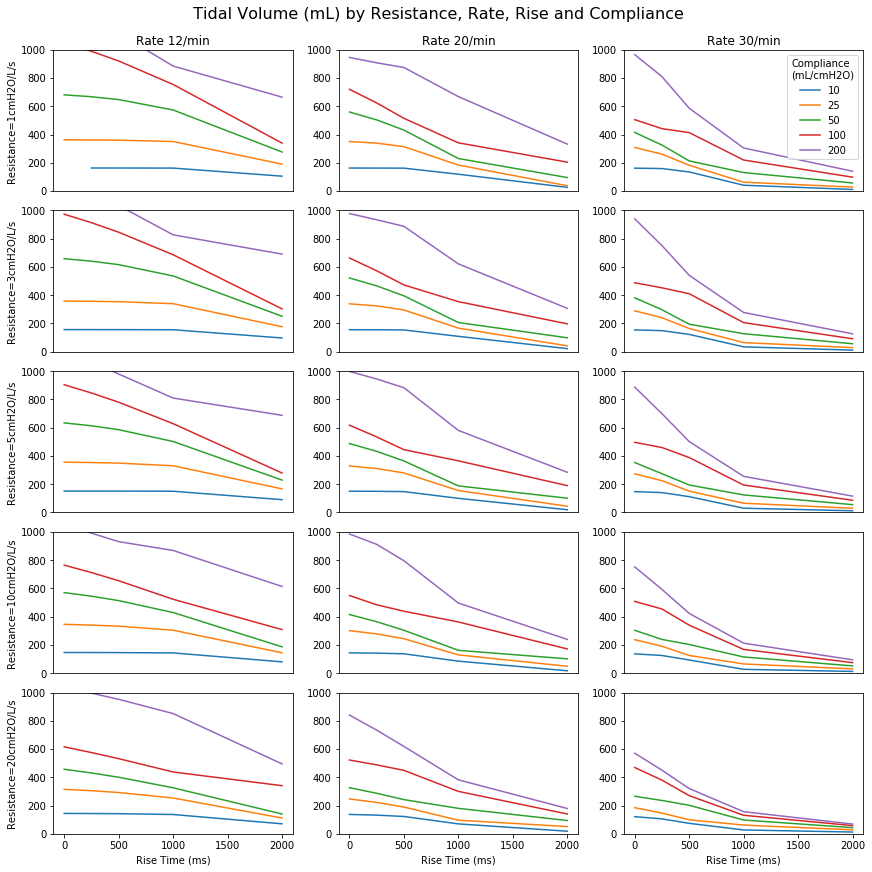

['rise', 'rate', 'resistance', 'compliance'] Rows = resistance, Cols = rate, X=rise, series=compliance 
WARNING went from 26 to 24 rows are cleaning {'rate': 12, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 20, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)
WARNING went from 26 to 25 rows are cleaning {'rate': 30, 'ie': 2, 'p': 20, 'peep': 5, 'resistance': 1} (This shouldn't really be happening!)


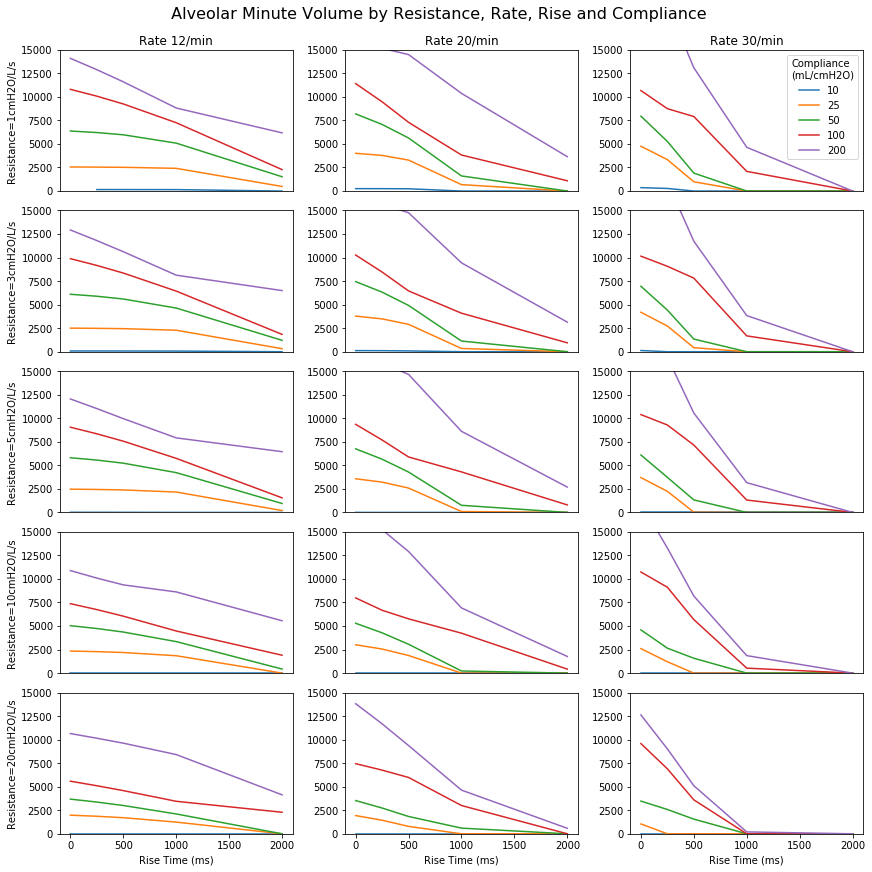

['rise', 'resistance', 'compliance', 'rate'] Rows = compliance, Cols = resistance, X=rise, series=rate 
WARNING went from 17 to 14 rows are cleaning {'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10, 'resistance': 1} (This shouldn't really be happening!)
WARNING went from 16 to 15 rows are cleaning {'ie': 2, 'p': 20, 'peep': 5, 'compliance': 25, 'resistance': 1} (This shouldn't really be happening!)


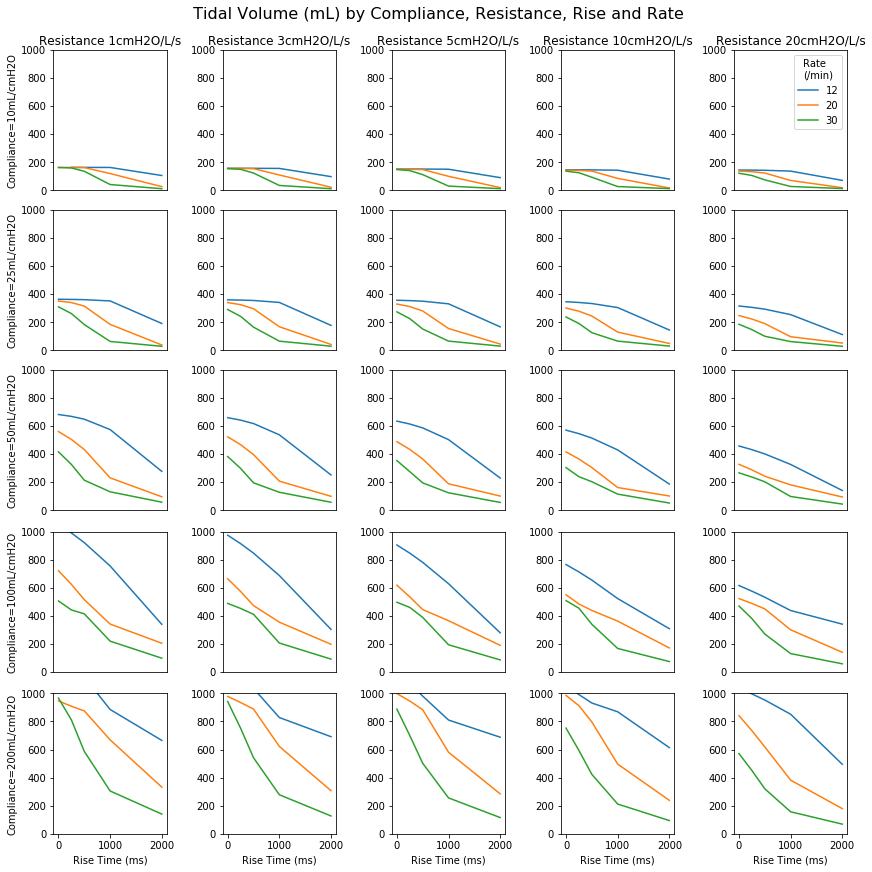

['rise', 'resistance', 'compliance', 'rate'] Rows = compliance, Cols = resistance, X=rise, series=rate 
WARNING went from 17 to 14 rows are cleaning {'ie': 2, 'p': 20, 'peep': 5, 'compliance': 10, 'resistance': 1} (This shouldn't really be happening!)
WARNING went from 16 to 15 rows are cleaning {'ie': 2, 'p': 20, 'peep': 5, 'compliance': 25, 'resistance': 1} (This shouldn't really be happening!)


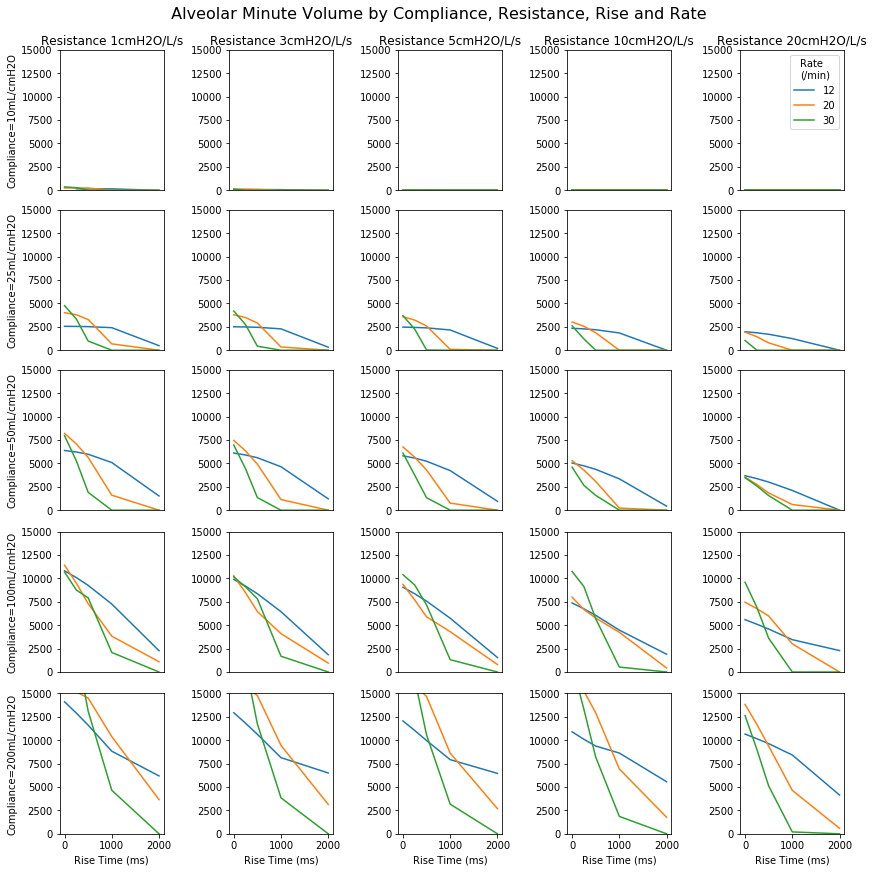

In [12]:
trace = 1
for priority in [
        ['rise', 'rate', 'compliance', 'resistance'],
        ['rise', 'rate', 'resistance', 'compliance'],
        ['rise', 'resistance', 'compliance','rate' ]]:
    for dependant in ['tv','alveolarMV']:
        display(HTML(f"<h1>Figure {trace}</h1>"))
        plot_matrix(data, priority, dependant=dependant)
        trace += 1


In [13]:
def describe(row):
    return {
        "Scenario": f"{row.index.name}={row.index[0]}", 
        "median tidal volume": round(row.median(axis=1).values[0],1),
        "median tidal volume at rise=0": row[0].values[0].round(1),
        "median tidal volume at rise=2000": row[2000].values[0].round(1),
        "difference": round(row[0].values[0]-row[2000].values[0], 1),
        "ratio": round(row[0].values[0]/row[2000].values[0],1)
    }
    #return f"{row.index.name} of {row.index[0]} median tidal volume ranged from {row.values.min():.0f} to {row.values.max():.0f}, a factor of {row.values.max()/row.values.min():.1f}"


for dependant in ['tv','alveolarMV']:
    ex = []
    for f in ['rate', 'compliance', 'resistance']:
        display(HTML(f"<h3>Median {pretty[dependant]} by {f.title()}</h3>"))
        #display(data.groupby([f])[['tv']].median().round(1))
        display(pd.crosstab(data[f], data.rise, values=data[dependant], aggfunc=np.median, margins=True).round(1))
        med = pd.crosstab(data[f], data.rise, values=data[dependant], aggfunc=np.median)
        ex.append(describe(med.head(1)))
        ex.append(describe(med.tail(1)))

    display(pd.DataFrame(ex))
    print('--')

rise,0,250,500,1000,2000,All
rate,,,,,,
12,615.5,575.3,532.2,437.6,209.8,414.7
20,451.1,432.6,364.3,187.8,98.8,297.8
30,331.0,274.2,202.0,123.8,55.1,166.0
All,415.0,380.0,349.0,206.1,98.6,293.9


rise,0,250,500,1000,2000,All
compliance,,,,,,
10,150.8,149.4,142.4,99.6,20.5,136.6
25,321.8,305.2,279.3,154.7,44.0,242.3
50,456.9,430.8,364.3,187.8,98.8,303.0
100,615.5,534.5,449.1,354.6,189.8,454.0
200,978.2,911.7,874.6,580.6,284.3,752.1
All,415.0,380.0,349.0,206.1,98.6,293.9


rise,0,250,500,1000,2000,All
resistance,,,,,,
1,415.0,441.6,413.8,230.1,105.2,335.8
3,488.3,452.5,395.8,206.7,98.8,307.1
5,487.6,432.6,364.3,193.8,100.7,284.3
10,414.6,363.9,332.4,167.6,94.2,277.8
20,326.5,305.2,270.2,156.7,70.7,236.1
All,415.0,380.0,349.0,206.1,98.6,293.9


,Scenario,median tidal volume,median tidal volume at rise=0,median tidal volume at rise=2000,difference,ratio
0,rate=12,532.2,615.5,209.8,405.8,2.9
1,rate=30,202.0,331.0,55.1,275.8,6.0
2,compliance=10,142.4,150.8,20.5,130.3,7.4
3,compliance=200,874.6,978.2,284.3,693.8,3.4
4,resistance=1,413.8,415.0,105.2,309.8,3.9
5,resistance=20,270.2,326.5,70.7,255.8,4.6


--


rise,0,250,500,1000,2000,All
rate,,,,,,
12,5586.4,5103.3,4586.3,3451.6,717.1,3176.1
20,6022.8,5651.5,4286.9,756.0,0.0,2956.9
30,5429.5,3725.8,1559.4,0.0,0.0,479.3
All,5586.4,4735.4,3284.5,1242.5,0.0,2444.3


/home/erich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


rise,0,250,500,1000,2000,All
compliance,,,,,,
10,10.4,0.0,0.0,0.0,0.0,0.0
25,2578.3,2484.3,1871.4,93.7,0.0,1853.8
50,6098.3,4735.4,3063.5,756.0,0.0,3346.9
100,9882.5,8463.7,6456.1,3823.9,795.9,6440.1
200,15914.4,13289.0,10620.6,7917.3,2687.0,10150.2
All,5586.4,4735.4,3284.5,1242.5,0.0,2444.3


/home/erich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


rise,0,250,500,1000,2000,All
resistance,,,,,,
1,6373.3,6212.1,5631.1,2087.0,0.0,2919.4
3,6956.1,5892.7,4916.5,1682.8,0.0,2908.7
5,6098.3,5559.0,4286.9,1313.4,0.0,2586.8
10,5037.3,4278.6,3063.5,527.6,0.0,2188.5
20,3529.0,2737.9,1838.8,201.6,0.0,1559.4
All,5586.4,4735.4,3284.5,1242.5,0.0,2444.3


/home/erich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


,Scenario,median tidal volume,median tidal volume at rise=0,median tidal volume at rise=2000,difference,ratio
0,rate=12,4586.3,5586.4,717.1,4869.3,7.8
1,rate=30,1559.4,5429.5,0.0,5429.5,inf
2,compliance=10,0.0,10.4,0.0,10.4,inf
3,compliance=200,10620.6,15914.4,2687.0,13227.4,5.9
4,resistance=1,5631.1,6373.3,0.0,6373.3,inf
5,resistance=20,1838.8,3529.0,0.0,3529.0,inf


--
